# CRF
In this lab session, you are going to train and test a linear-chain CRF model. Before starting, specify "python 3" in the environment parameters.

In [1]:
from itertools import chain
import nltk
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
import pycrfsuite

print(sklearn.__version__)

0.24.1


# Let's use CoNLL 2002 data to build a NER system

CoNLL2002 corpus is available in NLTK. We use Spanish data.

In [2]:
nltk.download('conll2002')
nltk.corpus.conll2002.fileids()

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\phile\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [3]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

Wall time: 2.6 s


Data format:

In [4]:
train_sents[:5]

[[('Melbourne', 'NP', 'B-LOC'),
  ('(', 'Fpa', 'O'),
  ('Australia', 'NP', 'B-LOC'),
  (')', 'Fpt', 'O'),
  (',', 'Fc', 'O'),
  ('25', 'Z', 'O'),
  ('may', 'NC', 'O'),
  ('(', 'Fpa', 'O'),
  ('EFE', 'NC', 'B-ORG'),
  (')', 'Fpt', 'O'),
  ('.', 'Fp', 'O')],
 [('-', 'Fg', 'O')],
 [('El', 'DA', 'O'),
  ('Abogado', 'NC', 'B-PER'),
  ('General', 'AQ', 'I-PER'),
  ('del', 'SP', 'I-PER'),
  ('Estado', 'NC', 'I-PER'),
  (',', 'Fc', 'O'),
  ('Daryl', 'VMI', 'B-PER'),
  ('Williams', 'NC', 'I-PER'),
  (',', 'Fc', 'O'),
  ('subrayó', 'VMI', 'O'),
  ('hoy', 'RG', 'O'),
  ('la', 'DA', 'O'),
  ('necesidad', 'NC', 'O'),
  ('de', 'SP', 'O'),
  ('tomar', 'VMN', 'O'),
  ('medidas', 'NC', 'O'),
  ('para', 'SP', 'O'),
  ('proteger', 'VMN', 'O'),
  ('al', 'SP', 'O'),
  ('sistema', 'NC', 'O'),
  ('judicial', 'AQ', 'O'),
  ('australiano', 'AQ', 'O'),
  ('frente', 'RG', 'O'),
  ('a', 'SP', 'O'),
  ('una', 'DI', 'O'),
  ('página', 'NC', 'O'),
  ('de', 'SP', 'O'),
  ('internet', 'NC', 'O'),
  ('que', 'PR', 'O'),

## Features

Next, define some features. In this example we use word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used. 

This makes a simple baseline, but you certainly can add and remove some features to get (much?) better results - experiment with it.

In [125]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag,
        'postag[:2]=' + postag[:2],
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:postag=' + postag1,
            '-1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('BOS')

    if i > 1:
        word1 = sent[i-2][0]
        postag1 = sent[i-2][1]
        features.extend([
            '-2:word.lower=' + word1.lower(),
            '-2:word.istitle=%s' % word1.istitle(),
            '-2:word.isupper=%s' % word1.isupper(),
            '-2:postag=' + postag1,
            '-2:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('BOS1')
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:postag=' + postag1,
            '+1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('EOS')

    if i < len(sent)-2:
        word1 = sent[i+2][0]
        postag1 = sent[i+2][1]
        features.extend([
            '+2:word.lower=' + word1.lower(),
            '+2:word.istitle=%s' % word1.istitle(),
            '+2:word.isupper=%s' % word1.isupper(),
            '+2:postag=' + postag1,
            '+2:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('EOS1')
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]    

This is what word2features extracts:

In [126]:
sent2features(train_sents[0])[0]

['bias',
 'word.lower=melbourne',
 'word[-3:]=rne',
 'word[-2:]=ne',
 'word.isupper=False',
 'word.istitle=True',
 'word.isdigit=False',
 'postag=NP',
 'postag[:2]=NP',
 'BOS',
 'BOS1',
 '+1:word.lower=(',
 '+1:word.istitle=False',
 '+1:word.isupper=False',
 '+1:postag=Fpa',
 '+1:postag[:2]=Fp',
 '+2:word.lower=australia',
 '+2:word.istitle=True',
 '+2:word.isupper=False',
 '+2:postag=NP',
 '+2:postag[:2]=NP']

Extract the features from the data:

In [127]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

Wall time: 4.14 s


In [128]:
y_test[0]

['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']

## Train the model

To train the model, we create pycrfsuite.Trainer, load the training data and call 'train' method. 
First, create pycrfsuite.Trainer and load the training data to CRFsuite:

In [129]:
%%time
trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

Wall time: 7.63 s


Set training parameters. We will use L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [130]:
trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 500,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

Possible parameters for the default training algorithm:

In [131]:
trainer.params()

['feature.minfreq',
 'feature.possible_states',
 'feature.possible_transitions',
 'c1',
 'c2',
 'max_iterations',
 'num_memories',
 'epsilon',
 'period',
 'delta',
 'linesearch',
 'max_linesearch']

Train the model:

In [132]:
%%time
trainer.train('conll2002-esp.crfsuite')

Wall time: 4min 52s


trainer.train saves model to a file:

We can also get information about the final state of the model by looking at the trainer's logparser. If we had tagged our input data using the optional group argument in add, and had used the optional holdout argument during train, there would be information about the trainer's performance on the holdout set as well. 

In [133]:
trainer.logparser.last_iteration

{'num': 500,
 'scores': {},
 'loss': 12483.106827,
 'feature_norm': 96.217025,
 'error_norm': 93.922685,
 'active_features': 6765,
 'linesearch_trials': 2,
 'linesearch_step': 0.5,
 'time': 0.986}

We can also get this information for every step using trainer.logparser.iterations

In [134]:
print(len(trainer.logparser.iterations), trainer.logparser.iterations[-1])

500 {'num': 500, 'scores': {}, 'loss': 12483.106827, 'feature_norm': 96.217025, 'error_norm': 93.922685, 'active_features': 6765, 'linesearch_trials': 2, 'linesearch_step': 0.5, 'time': 0.986}


In [135]:
min_iter = np.argmin([i["loss"] for i in trainer.logparser.iterations])
print(min_iter+1, trainer.logparser.iterations[min_iter])

500 {'num': 500, 'scores': {}, 'loss': 12483.106827, 'feature_norm': 96.217025, 'error_norm': 93.922685, 'active_features': 6765, 'linesearch_trials': 2, 'linesearch_step': 0.5, 'time': 0.986}


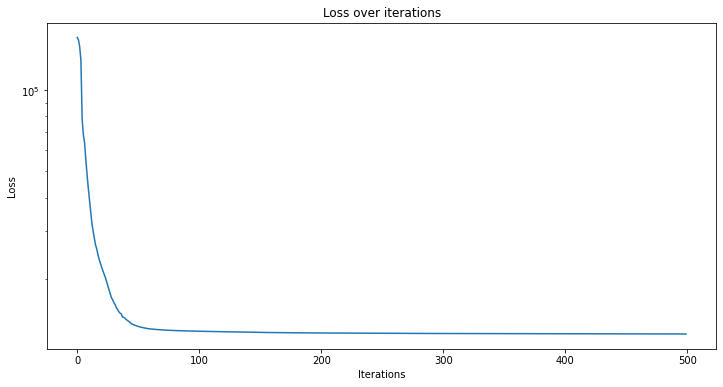

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(trainer.logparser.iterations)
plt.figure(figsize=(12,6))
plt.plot(df["loss"])
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.show()

## Make predictions

To use the trained model, create pycrfsuite.Tagger, open the model and use "tag" method:

In [141]:
tagger = pycrfsuite.Tagger()
tagger.open('conll2002-esp.crfsuite')

Let's tag a sentence to see how it works:

In [144]:
example_sent = test_sents[np.random.randint(len(test_sents))]
print(' '.join(sent2tokens(example_sent)))

print("Predicted:", ' '.join(tagger.tag(sent2features(example_sent))))
print("Correct:  ", ' '.join(sent2labels(example_sent)))

Ya en el verano de 1998 , cuando el mayor de los hermanos Laudrup colgó las botas después de los mundiales de Francia y de jugar 104 partidos internacionales para Dinamarca , se alzaron voces pidiendo la Cruz de Caballero para el veterano futbolista , y la Corte ha respondido ahora concendiendo a Michael la prestigiosa medalla .
Predicted: O O O O O O O O O O O O O B-PER O O O O O O O O B-LOC O O O O O O O B-LOC O O O O O O B-LOC I-LOC I-LOC O O O O O O O B-ORG O O O O O B-PER O O O O
Correct:   O O O O O O O O O O O O O B-PER O O O O O O O O B-LOC O O O O O O O B-LOC O O O O O O B-MISC I-MISC I-MISC O O O O O O O B-ORG O O O O O B-PER O O O O


## Evaluate the model

In [145]:
def bio_classification_report(y_true, y_pred):
    """
    Classification report for a list of BIO-encoded sequences.
    It computes token-level metrics and discards "O" labels.
    
    Note that it requires scikit-learn 0.15+ (or a version from github master)
    to calculate averages properly!
    """
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
        
    tagset = set(lb.classes_) - {'O'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
    )

Predict entity labels for all sentences in our testing set ('testb' Spanish data):

In [146]:
%%time
y_pred = [tagger.tag(xseq) for xseq in X_test]

Wall time: 928 ms


..and check the result. Note this report is not comparable to results in CONLL2002 papers because here we check per-token results (not per-entity). Per-entity numbers will be worse.  

In [147]:
print(bio_classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       B-LOC       0.79      0.76      0.78      1084
       I-LOC       0.69      0.66      0.67       325
      B-MISC       0.70      0.53      0.60       339
      I-MISC       0.71      0.63      0.67       557
       B-ORG       0.81      0.82      0.81      1400
       I-ORG       0.84      0.81      0.83      1104
       B-PER       0.84      0.89      0.86       735
       I-PER       0.87      0.94      0.90       634

   micro avg       0.80      0.79      0.79      6178
   macro avg       0.78      0.75      0.76      6178
weighted avg       0.80      0.79      0.79      6178
 samples avg       0.09      0.09      0.09      6178



C:\Users\phile\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phile\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Let's check what classifier learned

In [148]:
from collections import Counter
info = tagger.info()

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(info.transitions).most_common(15))

print("\nTop unlikely transitions:")
print_transitions(Counter(info.transitions).most_common()[-15:])

Top likely transitions:
B-PER  -> I-PER   7.325239
I-PER  -> I-PER   6.300165
B-LOC  -> I-LOC   5.662427
I-LOC  -> I-LOC   5.389338
I-MISC -> I-MISC  4.796620
I-ORG  -> I-ORG   4.737531
B-ORG  -> I-ORG   4.686419
B-MISC -> I-MISC  4.600614
I-PER  -> B-LOC   1.942600
O      -> B-MISC  1.556618
O      -> O       1.535889
O      -> B-ORG   1.046714
B-MISC -> B-ORG   0.392244
B-LOC  -> B-LOC   0.380783
I-PER  -> B-PER   0.300284

Top unlikely transitions:
I-ORG  -> I-PER   -2.168523
B-ORG  -> B-ORG   -2.169511
I-LOC  -> I-ORG   -2.269155
B-LOC  -> I-ORG   -2.298303
I-ORG  -> I-LOC   -2.312007
I-MISC -> I-LOC   -2.483062
B-ORG  -> I-LOC   -2.506781
I-ORG  -> I-MISC  -2.798127
B-MISC -> I-ORG   -2.808814
B-ORG  -> I-MISC  -2.833758
I-MISC -> I-ORG   -3.446892
O      -> I-PER   -10.028601
O      -> I-LOC   -10.667868
O      -> I-MISC  -11.130524
O      -> I-ORG   -11.202402


We can see that, for example, it is very likely that the beginning of an organization name (B-ORG) will be followed by a token inside organization name (I-ORG), but transitions to I-ORG from tokens with other labels are penalized. Also note I-PER -> B-LOC transition: a positive weight means that model thinks that a person name is often followed by a location.

Check the state features:

In [149]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-6s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(info.state_features).most_common(20))

print("\nTop negative:")
print_state_features(Counter(info.state_features).most_common()[-20:])

Top positive:
12.189127 B-ORG  word.lower=efe-cantabria
9.964828 B-ORG  word.lower=psoe-progresistas
8.868909 O      BOS
8.804382 B-ORG  word[-2:]=-e
7.831222 O      word.lower=a
6.946452 B-MISC BOS
6.733767 O      +1:word.lower=aniversario
5.810602 B-ORG  BOS
5.767970 B-PER  word.lower=mcmanaman
5.720163 I-MISC -1:word.lower=ibex
5.686791 O      -1:word.lower=siglo
5.642993 B-MISC word.lower=diversia
5.612087 B-MISC word.lower=opas
5.549818 I-PER  -1:word.lower=marqués
5.442271 B-ORG  word.lower=xfera
5.441704 B-LOC  -1:word.lower=cantabria
5.344577 O      postag[:2]=Fp
5.246953 O      word.lower=euro
5.227570 B-ORG  word.lower=efe
5.213560 I-ORG  -1:word.lower=antena

Top negative:
-2.180258 O      +1:word.lower=justicia
-2.292226 O      -1:word.lower=televisión
-2.313492 B-PER  word[-3:]=sta
-2.407376 I-PER  word[-3:]=ico
-2.426750 O      word[-3:]=bas
-2.439103 O      -1:word.lower=sección
-2.719386 O      word[-3:]=LOS
-2.802043 O      -1:word.lower=número
-2.950698 O      word.lo

Some observations:

* **8.743642 B-ORG  word.lower=psoe-progresistas** - the model remembered names of some entities - maybe it is overfit, or maybe our features are not adequate, or maybe remembering is indeed helpful;
* **5.195429 I-LOC  -1:word.lower=calle**: "calle" is a street in Spanish; model learns that if a previous word was "calle" then the token is likely a part of location;
* **-3.529449 O      word.isupper=True**, ** -2.913103 O      word.istitle=True **: UPPERCASED or TitleCased words are likely entities of some kind;
* **-2.585756 O      postag=NP** - proper nouns (NP is a proper noun in the Spanish tagset) are often entities.

# Coding your own CRF inference routine

To help you, we use a library, named flexcrf, that provide some inference routines you will use to test your viterbi algorithm. With the following command, you donwload and unzip it.

In [150]:
#!if [[ ! -d flexcrf_tp ]]; then wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HXmsF14bjBblD1DefwH1Q8Zy-KrAuCLG' -O flexcrf_tp.zip && unzip flexcrf_tp.zip;fi

Here, we import some functions


In [23]:
import pickle 
import numpy as np
from pycrfsuite import Tagger
from flexcrf_tp.models.linear_chain import (_feat_fun_values,
                                            _compute_all_potentials,
                                            _forward_score,
                                            _backward_score,
                                            _partition_fun_value,
                                            _posterior_score)

from flexcrf_tp.crfsuite2flexcrf import convert_data_to_flexcrf

#Viterbi decoder
Now you can complete the viterbi_decoder function:

In [123]:


# -- Define vitrebi_decoder here:

def viterbi_decoder(m_xy, n=None, log_version=True):
    """
    Performs MAP inference, determining $y = \argmax_y P(y|x)$, using the
    Viterbi algorithm.

    Parameters
    ----------
    m_xy : ndarray, shape (n_obs, n_labels, n_labels)
        Values of log-potentials ($\log M_i(y_{i-1}, y_i, x)$)
        computed based on feature functions f_xy and/or user-defined potentials
        `psi_xy`. At t=0, m_xy[0, 0, :] contains values of $\log M_1(y_0, y_1)$
        with $y_0$ the fixed initial state.

    n : integer, default=None
        Time position up to which to decode the optimal sequence; if not
        specified (default) the score is computed for the whole sequence.

    Returns
    -------
    y_pred : ndarray, shape (n_obs,)
        Predicted optimal sequence of labels.

    TODO: Cythonise this function for more efficiency.
    """

    if n is None:
        n = m_xy.shape[0]

    # Here we provide the temporary variables required by the viterbi algorithm.
    n_labels = m_xy.shape[2]
    y_pred = np.empty(n, dtype=int)
    delta = np.empty((n, n_labels))
    delta[0, :] = m_xy[0, 0, :] # Observation 0, état initial y0, tous les états possibles
    btrack = np.empty((n, n_labels), dtype=int)

    # Viterbi scores
    for i in range(1,n):
        delta[i,:] = np.max(delta[i-1,:]+m_xy[i,:,:].T,axis=1)
        btrack[i,:] = np.argmax(delta[i-1,:]+m_xy[i,:,:].T,axis=1)

    # Backtracking
    y_pred[0] = np.argmax(delta[-1])
    for i in range(y_pred.shape[0]-1):
        y_pred[i+1] = btrack[y_pred.shape[0]-1-i,y_pred[i]]
    
    return y_pred[::-1]

# Test your Viterbi decoder
Check if you viterbi decoder provide the same output as pycrfsuite.

In [124]:


# -- Load data and crfsuite model and convert them-------------------------

RECREATE = True  # set to True to recreate flexcrf data with new model

CRFSUITE_MODEL_FILE = './conll2002-esp.crfsuite'
CRFSUITE_MODEL_INFO_FILE = './conll2002-esp.crfsuite-model-info.dump'

CRFSUITE_TEST_DATA_FILE = './conll2002-esp_crfsuite-test-data.dump'
FLEXCRF_TEST_DATA_FILE = './conll2002-esp_flexcrf-test-data.dump'

# crfsuite model
tagger = Tagger()
tagger.open(CRFSUITE_MODEL_FILE)
model = tagger.info()
#model = pickle.load(open(CRFSUITE_MODEL_INFO_FILE))
#print "model loaded."
data={'X': X_test, 'y': y_test}
#data = pickle.load(open(CRFSUITE_TEST_DATA_FILE))
#print "test data loaded."

if RECREATE:
    dataset, thetas = convert_data_to_flexcrf(data, model, n_seq=3)
    pickle.dump({'dataset': dataset, 'thetas': thetas},
                open(FLEXCRF_TEST_DATA_FILE, 'wb'))
else:
    dd = pickle.load(open(FLEXCRF_TEST_DATA_FILE))
    dataset = dd['dataset']
    thetas = dd['thetas']

# -- Start classification ------------------------------------------------

for seq in range(len(dataset)):

    # -- with pycrfsuite
    s_ = tagger.tag(data['X'][seq])
    y_ = np.array([int(model.labels[s]) for s in s_])
    prob_ = tagger.probability(s_)

    print ("\n-- With crfsuite:")
    print ("labels:\n", s_, "\n", y_)
    print ("probability:\t %f" % prob_)

    # -- with flexcrf
    f_xy, y = dataset[seq]
    
    theta = thetas[seq]

    m_xy, f_m_xy = _compute_all_potentials(f_xy, theta)

    y_pred = viterbi_decoder(m_xy)

    alpha = _forward_score(m_xy)
    #beta = _backward_score(m_xy)
    z_x = _partition_fun_value(alpha)

    # compare flexcrf prob to crfsuill2002-esp.crfsuite-te prob
    f_x = _feat_fun_values(f_xy, y_, with_f_x_sum=False)
    prob0 = np.exp(_posterior_score(f_x=f_x, theta=theta, z_x=z_x))
    print ("flexcrf prob:\t %f" % prob0)

    f_x = _feat_fun_values(f_xy, y_pred, with_f_x_sum=False)
    prob = np.exp(_posterior_score(f_x=f_x, theta=theta, z_x=z_x))

    print ("-- With flexcrf:")
    print ("labels:\n", y_pred)
    print ("equal predictions: ", all(y_pred == y_))
    print ("probability:\t %f" % prob)
    print ("delta:\t %f" % abs(prob-prob_))

tagger.close()

f_xy_desc created.
t_xyy_desc created
Processing sentence 1/3...
Processing sentence 2/3...
Processing sentence 3/3...

-- With crfsuite:
labels:
 ['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O'] 
 [0 7 1 1 1 1 2 1 1]
probability:	 0.930321
flexcrf prob:	 0.930321
-- With flexcrf:
labels:
 [0 7 1 1 1 1 2 1 1]
equal predictions:  True
probability:	 0.930321
delta:	 0.000000

-- With crfsuite:
labels:
 ['O'] 
 [1]
probability:	 0.999996
flexcrf prob:	 0.999996
-- With flexcrf:
labels:
 [1]
equal predictions:  True
probability:	 0.999996
delta:	 0.000000

-- With crfsuite:
labels:
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O'] 
 [1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 3 4 4 1 1 1 1 1 0 7 1]
probability:	 0.437425
flexcrf pro